# Кошелев Александр

# Imports

In [87]:
import gym
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from loguru import logger
from collections import defaultdict
from copy import deepcopy

In [88]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [89]:
class BlackJackGamer(ABC):
    
    def __init__(self,  env) -> None:
        self.env = env
        
    @abstractmethod
    def run_episode(self):
        ...
             
    @abstractmethod
    def policy(self, observation) -> int:
        ...

# Пункт 1

In [9]:
env = gym.make("Blackjack-v1")
env.reset()

(13, 2, False)

## Simple Player

In [10]:
class SimplePlayer(BlackJackGamer):
    
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation)
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards
            
    def policy(self, observation) -> int:
        score, dealer_score, usable_ace = observation
        return 0 if score >= 19 else 1

In [11]:
simple_player = SimplePlayer(env)

In [12]:
states, actions, rewards = simple_player.run_episode()

In [13]:
gain = []
for _ in range(300000):
    states, actions, rewards = simple_player.run_episode()
    gain.append(rewards[-1])

In [14]:
np.mean(gain)

-0.19746666666666668

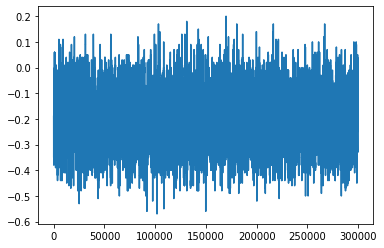

In [15]:
# plt.plot(gain_n.mean(axis=1)[:100])
plt.plot(moving_average(gain, 100))

## Q-learning Player

In [109]:
class QLearningPlayer(BlackJackGamer):
    
    def __init__(self, env, lr, gamma) -> None:
        super(QLearningPlayer, self).__init__(env)
        self.Q = {}
        self.lr = lr
        self.gamma = gamma
        
    def init_random_Q(self):
        self.Q = {}
        for i in range(12):
            self.Q[i] = np.array([0, 1])
        for i in range(22, 32):
            self.Q[i] = np.array([0, 0])
        for i in range(12, 22):
            self.Q[i] = np.random.random(2)
        self.Q[21][1] = 0
        self.Q[21][0] = 1
        
            
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        s, _, __ = observation 
        action = self.policy(observation, cnt)
        while True:
            states.append(s)        
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            s_prime, _, __ = observation
            a_prime = self.policy(observation)
            if s > 12 and s < 21:
                self.Q[s][action] = self.Q[s][action] + self.lr * (reward + self.gamma * np.max(self.Q[s_prime]) - self.Q[s][action])
            s, action = s_prime, a_prime
            rewards.append(reward)
            if done:
                return states, actions, rewards              
    
    def policy(self, observation) -> int:
        score, dealer_score, usable_ace = observation
        if score > 21:
            return 0
        return np.argmax(self.Q[score])

In [17]:
qlearningplayer = QLearningPlayer(env, 0.0001, 0.8)

In [18]:
qlearningplayer.init_random_Q()

In [19]:
gain = []
for _ in range(300000):
    states, actions, rewards = qlearningplayer.run_episode()
    gain.append(rewards[-1])

In [20]:
np.mean(gain)

-0.10941666666666666

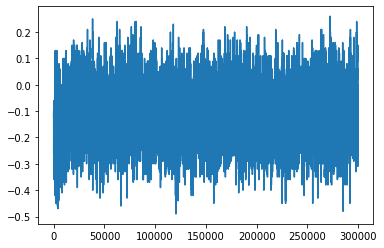

In [21]:
plt.plot(moving_average(gain, 100))

In [22]:
best_gain = -1
for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
    for gamma in [0.2, 0.4, 0.6, 0.8, 1]:
        qlearningplayer = QLearningPlayer(env, lr, gamma)
        qlearningplayer.init_random_Q()
        gain = []
        for _ in range(500000):
            states, actions, rewards = qlearningplayer.run_episode()
            gain.append(rewards[-1])
        mean_gain = np.mean(gain[-10000:])
        print(f"LR: {lr}, Gamma: {gamma}, mean gain {mean_gain}")
        if mean_gain > best_gain:
            best_gamma = gamma
            best_lr = lr
            best_gain = mean_gain

LR: 1e-05, Gamma: 0.2, mean gain -0.1014
LR: 1e-05, Gamma: 0.4, mean gain -0.1117
LR: 1e-05, Gamma: 0.6, mean gain -0.1
LR: 1e-05, Gamma: 0.8, mean gain -0.0636
LR: 1e-05, Gamma: 1, mean gain -0.1732
LR: 0.0001, Gamma: 0.2, mean gain -0.0767
LR: 0.0001, Gamma: 0.4, mean gain -0.1025
LR: 0.0001, Gamma: 0.6, mean gain -0.1214
LR: 0.0001, Gamma: 0.8, mean gain -0.1187
LR: 0.0001, Gamma: 1, mean gain -0.1258
LR: 0.001, Gamma: 0.2, mean gain -0.0779
LR: 0.001, Gamma: 0.4, mean gain -0.1012
LR: 0.001, Gamma: 0.6, mean gain -0.0993
LR: 0.001, Gamma: 0.8, mean gain -0.1261
LR: 0.001, Gamma: 1, mean gain -0.1942
LR: 0.01, Gamma: 0.2, mean gain -0.0948
LR: 0.01, Gamma: 0.4, mean gain -0.1295
LR: 0.01, Gamma: 0.6, mean gain -0.1229
LR: 0.01, Gamma: 0.8, mean gain -0.1186
LR: 0.01, Gamma: 1, mean gain -0.2003
LR: 0.1, Gamma: 0.2, mean gain -0.118
LR: 0.1, Gamma: 0.4, mean gain -0.2023
LR: 0.1, Gamma: 0.6, mean gain -0.1902
LR: 0.1, Gamma: 0.8, mean gain -0.2052
LR: 0.1, Gamma: 1, mean gain -0.1944

## Выводы пункт 1

Средний проигрыш наивного игрока 0.2 <br>
Средний проигрыш лучшего игрока (с параметрами lr=1e-05, gamma=0,8) 0.0636 <br>

# Пункт 2

In [23]:
class QDoublePlayer(BlackJackGamer):
    
    def __init__(self, env, lr, gamma) -> None:
        super(QDoublePlayer, self).__init__(env)
        self.Q = {}
        self.lr = lr
        self.gamma = gamma
        self.last_action = 0
        
    def init_random_Q(self):
        self.Q = {}
        for i in range(12):
            self.Q[i] = np.array([0, 1, 0])
        for i in range(22, 32):
            self.Q[i] = np.array([0, 0, 0])
        for i in range(12, 22):
            self.Q[i] = np.random.random(3)
        self.Q[21][2] = 0
        self.Q[21][1] = 0
        self.Q[21][0] = 1
        
    
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        s, _, __ = observation 
        action = self.policy(observation)
        while True:
            states.append(s)        
            actions.append(action)
            observation, reward, done, info = self.new_step(action)
            s_prime, _, __ = observation
            a_prime = self.policy(observation)
            if s > 12 and s < 21:
                self.Q[s][action] = self.Q[s][action] + self.lr * (reward + self.gamma * np.max(self.Q[s_prime]) - self.Q[s][action])
            s, action = s_prime, a_prime
            rewards.append(reward)
            if done:
                return states, actions, rewards              
    
    def policy(self, observation) -> int:
        score, dealer_score, usable_ace = observation
        if self.last_action == 2:
            action = 0
        else:
            action = np.argmax(self.Q[score])
        self.last_action = action
        return action
    
    def new_step(self, action):
        action_for_env = action if action != 2 else 1
        observation, reward, done, info = self.env.step(action_for_env)
        if action == 2:
            reward *= 2
        return observation, reward, done, info

In [24]:
qlearningplayer = QDoublePlayer(env, 0.0001, 0.8)
qlearningplayer.init_random_Q()
gain = []
for _ in range(300000):
    states, actions, rewards = qlearningplayer.run_episode()
    gain.append(rewards[-1])

In [25]:
mean_gain = np.mean(gain[-10000:])

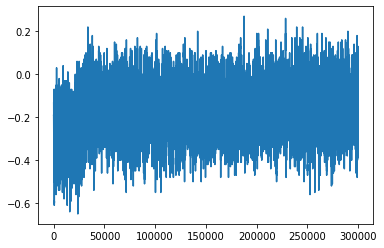

In [26]:
plt.plot(moving_average(gain, 100))

In [27]:
best_gain = -1
for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
    for gamma in [0.2, 0.4, 0.6, 0.8, 1]:
        qdoubleplayer = QDoublePlayer(env, lr, gamma)
        qdoubleplayer.init_random_Q()
        for _ in range(500000):
            states, actions, rewards = qdoubleplayer.run_episode()
            gain.append(rewards[-1])
        mean_gain = np.mean(gain[-100000:])
        print(f"LR: {lr}, Gamma: {gamma}, mean gain {mean_gain}")
        if mean_gain > best_gain:
            best_gamma = gamma
            best_lr = lr
            best_gain = mean_gain

LR: 1e-05, Gamma: 0.2, mean gain -0.20762
LR: 1e-05, Gamma: 0.4, mean gain -0.5225
LR: 1e-05, Gamma: 0.6, mean gain -0.14126
LR: 1e-05, Gamma: 0.8, mean gain -0.27646
LR: 1e-05, Gamma: 1, mean gain -0.11208
LR: 0.0001, Gamma: 0.2, mean gain -0.12646
LR: 0.0001, Gamma: 0.4, mean gain -0.14833
LR: 0.0001, Gamma: 0.6, mean gain -0.16584
LR: 0.0001, Gamma: 0.8, mean gain -0.15841
LR: 0.0001, Gamma: 1, mean gain -0.10614
LR: 0.001, Gamma: 0.2, mean gain -0.07762
LR: 0.001, Gamma: 0.4, mean gain -0.10742
LR: 0.001, Gamma: 0.6, mean gain -0.13946
LR: 0.001, Gamma: 0.8, mean gain -0.11168
LR: 0.001, Gamma: 1, mean gain -0.2982
LR: 0.01, Gamma: 0.2, mean gain -0.11583
LR: 0.01, Gamma: 0.4, mean gain -0.1095
LR: 0.01, Gamma: 0.6, mean gain -0.11269
LR: 0.01, Gamma: 0.8, mean gain -0.1216
LR: 0.01, Gamma: 1, mean gain -0.12813
LR: 0.1, Gamma: 0.2, mean gain -0.12334
LR: 0.1, Gamma: 0.4, mean gain -0.19907
LR: 0.1, Gamma: 0.6, mean gain -0.20089
LR: 0.1, Gamma: 0.8, mean gain -0.17504
LR: 0.1, Gam

## Выводы пункт 2

Средний проигрыш лучшего игрока (с параметрами lr=0.001, gamma=0,2) 0.07762 <br>

# Пункт 3

В этот раз не получилось воспользоваться готовой средой, поэтому возьмем из задания. Для подсчета карт использовал стратегию  «Плюс-минус»  https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA

In [145]:
def cmp(a, b):
    return float(a > b) - float(a < b)

class BlackjackDoubleCountingEnv(gym.Env):
    
    def __init__(self):
        self.plus_minus_count = {
            2: 1,
            3: 1,
            4: 1,
            5: 1,
            6: 1,
            7: 0,
            8: 0,
            9: 0,
            10: -1,
            11: -1,
        }
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(42)))
        self.seed()
        self.full_deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4
        self.deck = deepcopy(self.full_deck)
        self.count = 0
        self.reset()


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            card = self.draw_card()
            self.count_card(card)
            self.player.append(card)
            if self.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            for card in self.dealer[1:]:
                self.count_card(card)
            reward = cmp(self.score(self.player), self.score(self.dealer))

        elif action == 2:
            card = self.draw_card()
            self.count_card(card)
            self.player.append(card)
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            for card in self.dealer[1:]:
                self.count_card(card)
            reward = cmp(self.score(self.player), self.score(self.dealer)) * 2
            
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], False, self.count)
    
    def count_card(self, card):
        self.count += self.plus_minus_count[card] 

    def reset(self):
        if len(self.deck) < 15:
            self.deck = deepcopy(self.full_deck)
            self.count = 0
        self.dealer = self.draw_hand()
        self.count_card(self.dealer[0])
        self.player = self.draw_hand()
        self.count_card(self.player[0])
        self.count_card(self.player[1])
        return self._get_obs()
    
    def draw_card(self):
        card = np.random.choice(self.deck)
        self.deck.remove(card)
        return card


    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    @staticmethod
    def sum_hand(hand):
        return sum(hand)
    
    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

In [146]:
custom_env = BlackjackDoubleCountingEnv()

In [147]:
custom_env.reset()

(16, 6, False, 0)

In [148]:
class QDustinPlayer(BlackJackGamer):
    
    def __init__(self, env, lr, gamma) -> None:
        super(QDustinPlayer, self).__init__(env)
        self.Q = {}
        self.lr = lr
        self.gamma = gamma
        self.last_action = 0
        
    def init_random_Q(self):
        self.Q = defaultdict(dict)
        for counter in range(-22, 23):
            for i in range(12):
                self.Q[counter][i] = np.array([0, 1, 0])
            for i in range(22, 32):
                self.Q[counter][i] = np.array([0, 0, 0])
            for i in range(12, 22):
                self.Q[counter][i] = np.random.random(3)
            self.Q[counter][21][2] = 0
            self.Q[counter][21][1] = 0
            self.Q[counter][21][0] = 1
        
    
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        s, _, __, cnt = observation 
        action = self.policy(observation, cnt)
        while True:
            states.append(s)        
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            s_prime, _, __, cnt = observation
            a_prime = self.policy(observation, cnt)
            if s > 12 and s < 21:
                self.Q[cnt][s][action] = self.Q[cnt][s][action] + self.lr * (reward + self.gamma * np.max(self.Q[cnt][s_prime]) - self.Q[cnt][s][action])
            s, action = s_prime, a_prime
            rewards.append(reward)
            if done:
                return states, actions, rewards              
    
    def policy(self, observation, count) -> int:
        score, dealer_score, usable_ace, _ = observation
        if score > 21:
            return 0
        return np.argmax(self.Q[count][score])

In [170]:
dustin = QDustinPlayer(custom_env, 0.0001, 0.4)

In [171]:
dustin.init_random_Q()

In [ ]:
gain = []
for _ in range(10000000):
    states, actions, rewards = dustin.run_episode()
    gain.append(rewards[-1])

In [168]:
np.mean(gain[-100000:])

-0.10748

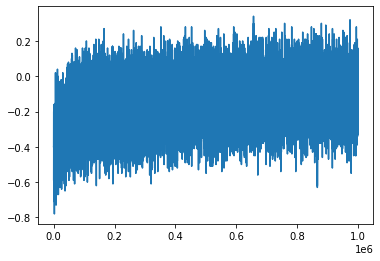

In [169]:
plt.plot(moving_average(gain, 100))

In [156]:
best_gain = -1
for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
    for gamma in [0.2, 0.4, 0.6, 0.8, 1]:
        dustin = QDustinPlayer(custom_env, lr, gamma)
        dustin.init_random_Q()
        for _ in range(500000):
            states, actions, rewards = dustin.run_episode()
            gain.append(rewards[-1])
        mean_gain = np.mean(gain[-100000:])
        print(f"LR: {lr}, Gamma: {gamma}, mean gain {mean_gain}")
        if mean_gain > best_gain:
            best_gamma = gamma
            best_lr = lr
            best_gain = mean_gain

LR: 1e-05, Gamma: 0.2, mean gain -0.44777


KeyboardInterrupt: 

# end